## Feature Selection

This '.ipynb' file contains some agressive feature selection to reduce the total of a litte over 32000 features down to a manageble count valuable for training. This wil be done trough various methods:

- Inital feature selection of clinical data
- Dropping duplicates
- Dropping NaN values
- Fracting thresholding
- Variance thresholding
- Correlation thresholding
- More...

By aplying al of these feature reducing methods whe hope to reduce the total feature count to a maximun of a couple honderd to a thousend features.

#### 1. NaN and Duplicates

The prepricessed dataset is loaded in, and the two different types of columns are defined. Extra clinical features are dropped.Then rows with duplicate 'case_id' are dropped, so only one row per case remains. Lastly possible rows with NaN values are dropped to ensure error free feature selection and model training. 

In [ ]:
import pandas as pd

# Loading the preprocessed dataset
dataFrame: pd.DataFrame = pd.read_csv('./DatasetParser/Dataset/ProcessedFiles/merged_data.csv', low_memory=False)

# Retrieving all the unique cases from the dataset
dataFrame.drop_duplicates(subset=['case_id'], inplace=True)

# Function to get all columns related to genes
def getGeneColumns():
    return [col for col in dataFrame.columns if 'unstranded' in col]

# Selecting all the unstranded and tpm_unstranded columns
geneColumns: list[str] = getGeneColumns()

# Defining the clinical columns to be retained
clinicalColumns: list[str] = [
    #'case_id', 
    #'histological_type', 
    'icd_o_3_histology'
    ]

# Checking rows for NaN values in specific columns
selectedColumns: list[str] = clinicalColumns + geneColumns

# Keeping only the selected columns
dataFrame = dataFrame[selectedColumns]

# Dropping rows with any NaN values
dataFrame.dropna(inplace=True)

In [ ]:

def classify_histology(icd_code: str) -> int:
    try:
        main_code = int(icd_code.split("/")[0])
    except:
        return False
    if 8050 <= main_code <= 8078:
        return True  # Squamous
    elif main_code == 8140:
        return False  # Adenocarcinoma
    return False

dataFrame['icd_o_3_histology'] = dataFrame['icd_o_3_histology'].astype(str).apply(classify_histology)

print(dataFrame['icd_o_3_histology'].value_counts())

icd_o_3_histology
False    532
True     486
Name: count, dtype: int64


#### 2. Mixed data types

Any colums with mixed data types are dropped to ensure correct model training, and feature reducting.

In [ ]:

# Identifying columns with mixed data types
mixedTypeColumns: list[str] = [
    col for col in dataFrame.columns
    if dataFrame[col].map(type).nunique() > 1
]

# Dropping columns with mixed data types
dataFrame.drop(columns=mixedTypeColumns, inplace=True)

# Keeping the gene columns up-to-date
geneColumns = getGeneColumns()

### 3. Fraction Threshold

Any genes that where 80% of the sampels have a value lower that 80% wil be dropped, these genes likely do not play a large role in detecting histology subtypes.

In [ ]:
countThreshold: int = 5
sampleFractionThreshold: float = 0.8

# Creating a mask for the data frame so only the active genes are included
mask = (dataFrame[geneColumns] < countThreshold).sum(axis=0) > (sampleFractionThreshold * dataFrame[geneColumns].shape[0])

# Creating a filterd data frame
filterdDataFrame: pd.DataFrame = dataFrame[geneColumns].loc[:, ~mask]

# Updating the gene columns to ensure correct indexing
geneColumns = filterdDataFrame.columns

# Updating the original dataframe
dataFrame = dataFrame[clinicalColumns].join(filterdDataFrame)

print(dataFrame)

      icd_o_3_histology  LINC01587_unstranded  AC016026.1_unstranded  \
0                 False                   2.0                    6.0   
1                 False                  13.0                    0.0   
2                 False                 294.0                    1.0   
3                 False                   6.0                    3.0   
5                 False                   6.0                    9.0   
...                 ...                   ...                    ...   
1157              False                   5.0                   14.0   
1158               True                   1.0                    7.0   
1159               True                  44.0                    5.0   
1160               True                  76.0                   31.0   
1161               True                   1.0                    9.0   

      IGF2-AS_unstranded  RRN3P2_unstranded  DLEU2L_unstranded  \
0                    0.0               10.0                6.0   
1  

#### 4. Variance threshold

Small variance between gene samples have litte to no value to the global model training and can be dropped.

In [ ]:
# TODO: Seems to not drop any extra columns, but just in case

from sklearn.feature_selection import VarianceThreshold

# Define a threshold for variance
varianceThreshold: int = 15  

# Step 1: Select only the feature columns (ensure no NaNs)
threshHoldDataFrame: pd.DataFrame = dataFrame[geneColumns].copy()

# Step 2: Apply VarianceThreshold
selector = VarianceThreshold(threshold=varianceThreshold) # TODO find logical value
X_selected = selector.fit_transform(threshHoldDataFrame)

# Step 3: Get selected column names
selectedColumns: list[str] = threshHoldDataFrame.columns[selector.get_support()]

# Step 4: Create a new DataFrame with selected features
filterdDataFrame = pd.DataFrame(X_selected, columns=selectedColumns, index=dataFrame.index)

# Step 5: Drop original gene columns and add the reduced set
dataFrame = dataFrame.drop(columns=geneColumns).join(filterdDataFrame)

# Updating the geneColumns to reflect the reduced set
geneColumns = selectedColumns.tolist()

print(dataFrame)

      icd_o_3_histology  LINC01587_unstranded  AC016026.1_unstranded  \
0                 False                   2.0                    6.0   
1                 False                  13.0                    0.0   
2                 False                 294.0                    1.0   
3                 False                   6.0                    3.0   
5                 False                   6.0                    9.0   
...                 ...                   ...                    ...   
1157              False                   5.0                   14.0   
1158               True                   1.0                    7.0   
1159               True                  44.0                    5.0   
1160               True                  76.0                   31.0   
1161               True                   1.0                    9.0   

      IGF2-AS_unstranded  RRN3P2_unstranded  DLEU2L_unstranded  \
0                    0.0               10.0                6.0   
1  

In [ ]:
X = dataFrame.drop(columns=["icd_o_3_histology"])  # All gene features
y = dataFrame["icd_o_3_histology"]   


from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

# 1. Scale the features first (Lasso is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Fit Lasso and SelectFromModel
lasso = Lasso(alpha=0.01)
selector = SelectFromModel(lasso)
selector.fit(X_scaled, y)

# 3. Get selected feature mask
mask = selector.get_support()

# 4. Use mask to trim original DataFrame (preserving column names)
selected_features = X.columns[mask]
dataFrame = X[selected_features]

# join the icd_o_3_histology column back
dataFrame = dataFrame.join(y)

geneColumns = getGeneColumns()

print(dataFrame)

      IGF2-AS_unstranded  RRN3P2_unstranded  C22orf24_unstranded  \
0                    0.0               10.0                  7.0   
1                    3.0                5.0                  6.0   
2                    7.0                2.0                 13.0   
3                    0.0               14.0                 24.0   
5                    3.0                7.0                 36.0   
...                  ...                ...                  ...   
1157                 1.0                1.0                 32.0   
1158                 1.0               10.0                 24.0   
1159                 7.0                0.0                 25.0   
1160                 1.0                3.0                 25.0   
1161                 2.0                5.0                 61.0   

      LINC00476_unstranded  LINC00469_unstranded  C22orf34_unstranded  \
0                     63.0                   1.0                 38.0   
1                     81.0           

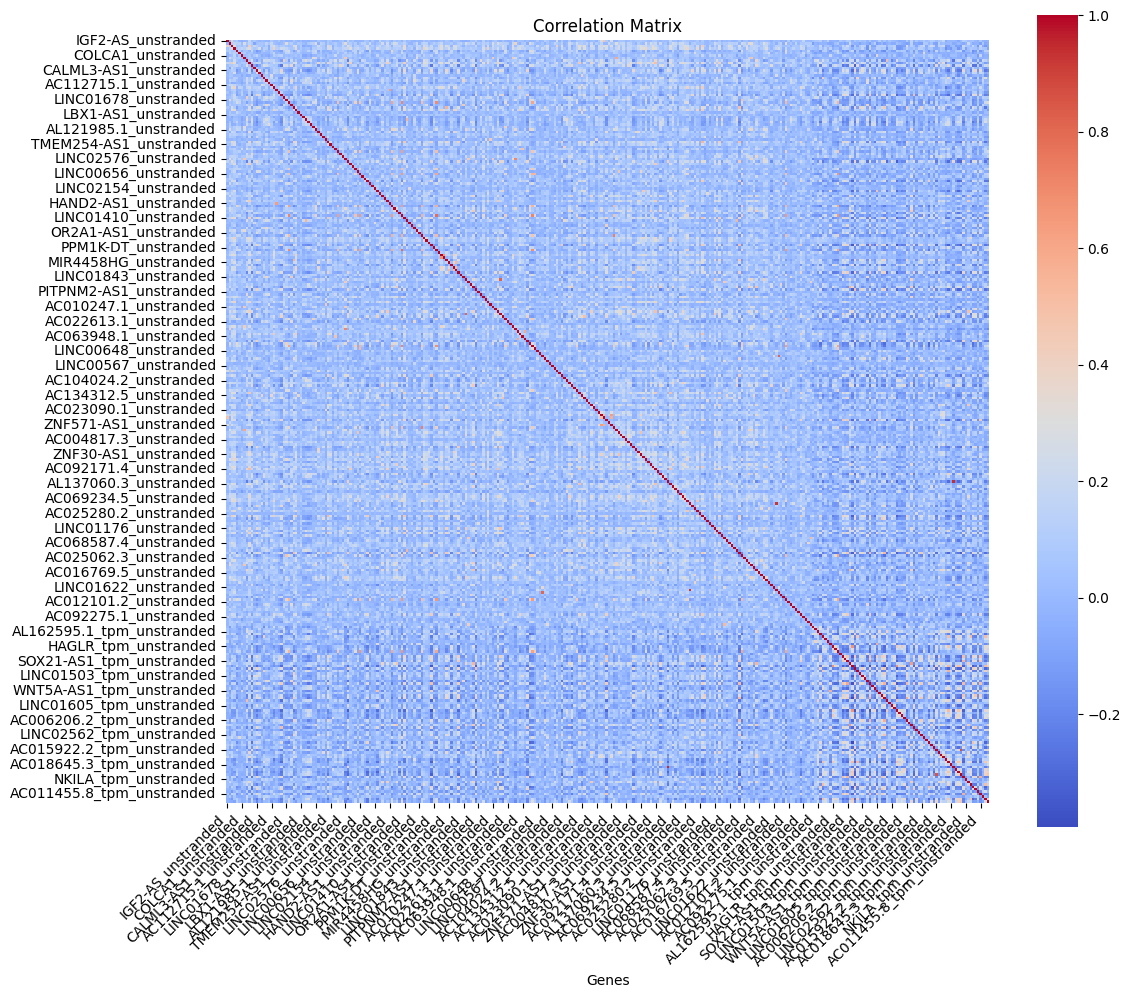

      IGF2-AS_unstranded  RRN3P2_unstranded  C22orf24_unstranded  \
0                    0.0               10.0                  7.0   
1                    3.0                5.0                  6.0   
2                    7.0                2.0                 13.0   
3                    0.0               14.0                 24.0   
5                    3.0                7.0                 36.0   
...                  ...                ...                  ...   
1157                 1.0                1.0                 32.0   
1158                 1.0               10.0                 24.0   
1159                 7.0                0.0                 25.0   
1160                 1.0                3.0                 25.0   
1161                 2.0                5.0                 61.0   

      LINC00476_unstranded  LINC00469_unstranded  C22orf34_unstranded  \
0                     63.0                   1.0                 38.0   
1                     81.0           

In [ ]:
# Creating a correlation matrix
correlationMatrix = dataFrame[geneColumns].corr()

# Defining a threshold for correlation
correlationThreshold = 0.75 

# Finding pairs of columns with correlation above the threshold
selectedColumns = set()
for i in range(len(correlationMatrix.columns)):
    for j in range(i):
        if abs(correlationMatrix.iloc[i, j]) > correlationThreshold:
            colname = correlationMatrix.columns[i]
            selectedColumns.add(colname)

# Converting the set to a list
selectedColumns: list[str] = list(selectedColumns)

# Dropping the selected columns from the original DataFrame
dataFrame.drop(columns=selectedColumns, inplace=True)

# plotting the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
# Hide value labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel('Genes')

plt.title('Correlation Matrix')
plt.show()

print(dataFrame)

In [ ]:
X = dataFrame.drop(columns=["icd_o_3_histology"])  # All gene features
y = dataFrame["icd_o_3_histology"]   

from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

mask = selector.get_support()
selected_feature_names = X.columns[mask]

# Trim the DataFrame
dataFrame = X[selected_feature_names]

# join the icd_o_3_histology column back
dataFrame = dataFrame.join(y)

geneColumns = getGeneColumns()

print(dataFrame)

      AC079465.1_unstranded  KLRK1-AS1_unstranded  AL033530.1_unstranded  \
0                       3.0                  21.0                   94.0   
1                       2.0                  61.0                    0.0   
2                       5.0                  88.0                    1.0   
3                       0.0                  20.0                   33.0   
5                       5.0                  50.0                    0.0   
...                     ...                   ...                    ...   
1157                    5.0                 190.0                  211.0   
1158                    3.0                 397.0                  157.0   
1159                   10.0                 557.0                  219.0   
1160                    2.0                 113.0                    6.0   
1161                    2.0                 332.0                   34.0   

      SFTA3_tpm_unstranded  MIR205HG_tpm_unstranded  \
0                   1.7698      

#### 5. Correlation threshold

Any correlated features have litte to no extra value to be includeded in model training and can be dropped.

Accuracy: 0.9254901960784314
Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.97      0.93       132
        True       0.96      0.88      0.92       123

    accuracy                           0.93       255
   macro avg       0.93      0.92      0.93       255
weighted avg       0.93      0.93      0.93       255



Text(0.5, 0, 'False Positive Rate')

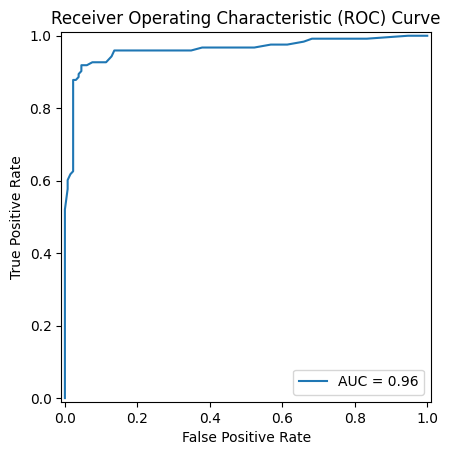

In [ ]:
randomSeed = 645

# Training a random forest classifier and splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X = dataFrame.drop(columns=["icd_o_3_histology"])  # All gene features
y = dataFrame["icd_o_3_histology"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=randomSeed)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=randomSeed)
rf.fit(X_train, y_train)
# Evaluating the model
from sklearn.metrics import classification_report, accuracy_score
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# plotting roc and using the AUC score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')

In [ ]:
# TRaining and testing alogistical regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000, random_state=randomSeed)
log_reg.fit(X_train, y_train)
# Evaluating the logistic regression model
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))

Logistic Regression Accuracy: 0.9098039215686274


In [ ]:
# training ans testing a support vector machine model
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=randomSeed)
svm_model.fit(X_train, y_train)
# Evaluating the SVM model
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.9176470588235294
